# Trial‑by‑trial CoDA (uncertainty‑aware) — acquisition → extinction with live metrics

This notebook reproduces the *trial‑by‑trial* style plots from your original code,
but adds uncertainty gating for splits. It records **per‑episode** time‑series:
- Prospective contingency `PC` at the (original) cue state
- Posterior tail probability `Pr[p>theta_split]` at the cue
- Effective exposure `E_r + E_nr` at the cue
- Retrospective contingency `RC` at the cue
- Number of states (clones) in the model
- Split / merge event flags


In [1]:

import sys, numpy as np, matplotlib.pyplot as plt
sys.path.append('/mnt/data')

from coda_trial_by_trial import (
    CoDAAgent, CoDAConfig,
    GridEnvRightDownNoSelf, GridEnvRightDownNoCue,
    generate_episode, posterior_prob_p_greater_than
)

# --- Config ---
CUE = 5                    # original cue state id in the demo env
T_SPLIT = 0.9              # split threshold (also in config)
CONF   = 0.95              # posterior tail confidence
N_ACQ  = 300               # episodes for acquisition
N_EXT  = 350               # episodes for extinction
MAX_STEPS = 20

cfg = CoDAConfig(
    gamma=0.9, lam=0.8,
    theta_split=T_SPLIT, theta_merge=0.5,
    n_threshold=8,
    min_presence_episodes=8,
    min_effective_exposure=25.0,
    confidence=CONF,
    alpha0=0.5, beta0=0.5
)

env = GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
agent = CoDAAgent(env, cfg)

# Pre-allocate logs
T_total = N_ACQ + N_EXT
PC  = np.zeros(T_total)
RC  = np.zeros(T_total)
EXP = np.zeros(T_total)
TAIL = np.zeros(T_total)
NSTATES = np.zeros(T_total, dtype=int)
SPLIT_FLAG = np.zeros(T_total, dtype=int)
MERGE_FLAG = np.zeros(T_total, dtype=int)


In [2]:

# --- Acquisition ---
with_clones = False
t = 0
for ep in range(1, N_ACQ+1):
    states, actions = generate_episode(env, T=agent.get_T() if with_clones else None, max_steps=MAX_STEPS)
    agent.update_with_episode(states, actions)
    new = agent.maybe_split()
    if new:
        with_clones = True
        SPLIT_FLAG[t] = 1

    pc = agent.prospective(); rc = agent.retrospective()
    PC[t]  = pc[CUE] if CUE < pc.size else np.nan
    RC[t]  = rc[CUE] if CUE < rc.size else np.nan
    EXP[t] = (agent.E_r + agent.E_nr).reshape(-1)[CUE] if CUE < agent.E_r.shape[1] else np.nan
    TAIL[t] = posterior_prob_p_greater_than(cfg.theta_split,
                                            agent.E_r[0, CUE] if CUE < agent.E_r.shape[1] else 0.0,
                                            agent.E_nr[0, CUE] if CUE < agent.E_nr.shape[1] else 0.0,
                                            cfg.alpha0, cfg.beta0)
    NSTATES[t] = agent.n_states
    t += 1

# --- Extinction (degrade informativeness) ---
env2 = GridEnvRightDownNoCue(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
env2.clone_dict = dict(agent.env.clone_dict)
env2.reverse_clone_dict = dict(agent.env.reverse_clone_dict)
agent.env = env2

for ep in range(N_ACQ+1, N_ACQ+N_EXT+1):
    states, actions = generate_episode(env2, T=agent.get_T(), max_steps=MAX_STEPS)
    agent.update_with_episode(states, actions)
    merged = agent.maybe_merge()
    if merged:
        MERGE_FLAG[t] = 1

    pc = agent.prospective(); rc = agent.retrospective()
    PC[t]  = pc[CUE] if CUE < pc.size else np.nan
    RC[t]  = rc[CUE] if CUE < rc.size else np.nan
    EXP[t] = (agent.E_r + agent.E_nr).reshape(-1)[CUE] if CUE < agent.E_r.shape[1] else np.nan
    TAIL[t] = posterior_prob_p_greater_than(cfg.theta_split,
                                            agent.E_r[0, CUE] if CUE < agent.E_r.shape[1] else 0.0,
                                            agent.E_nr[0, CUE] if CUE < agent.E_nr.shape[1] else 0.0,
                                            cfg.alpha0, cfg.beta0)
    NSTATES[t] = agent.n_states
    t += 1

print("Total splits:", SPLIT_FLAG.sum(), "| Total merges:", MERGE_FLAG.sum())


Total splits: 1 | Total merges: 0


## Plots (one metric per figure, matching your trial‑by‑trial style)

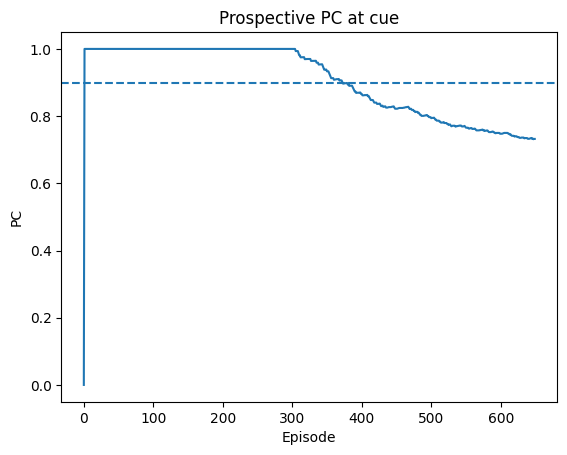

In [3]:

# 1) Prospective contingency at cue (with split threshold)
plt.figure()
plt.title("Prospective PC at cue")
plt.plot(PC)
plt.axhline(T_SPLIT, linestyle='--')
plt.xlabel("Episode"); plt.ylabel("PC")
plt.show()


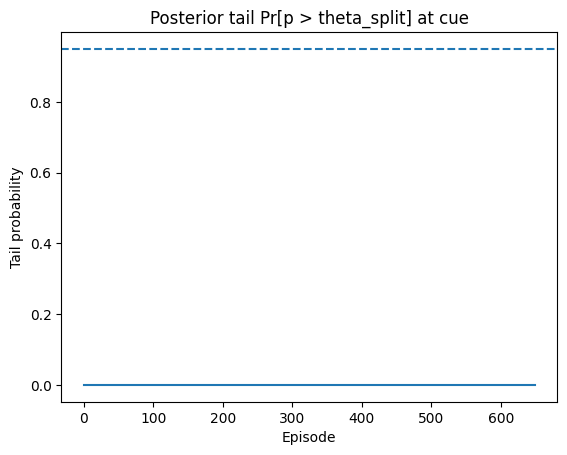

In [4]:

# 2) Posterior tail probability at cue (with confidence line)
plt.figure()
plt.title("Posterior tail Pr[p > theta_split] at cue")
plt.plot(TAIL)
plt.axhline(CONF, linestyle='--')
plt.xlabel("Episode"); plt.ylabel("Tail probability")
plt.show()


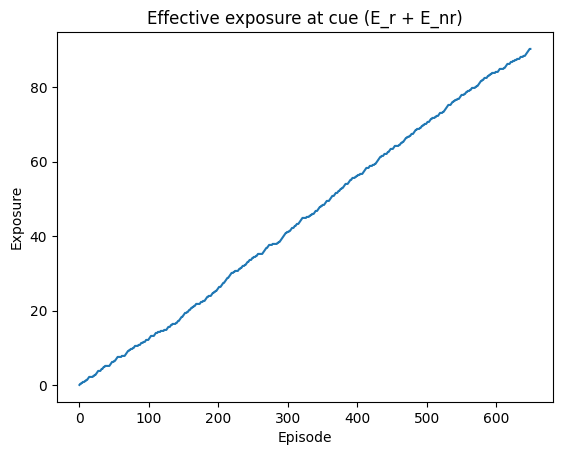

In [5]:

# 3) Effective exposure (E_r + E_nr) at cue
plt.figure()
plt.title("Effective exposure at cue (E_r + E_nr)")
plt.plot(EXP)
plt.xlabel("Episode"); plt.ylabel("Exposure")
plt.show()


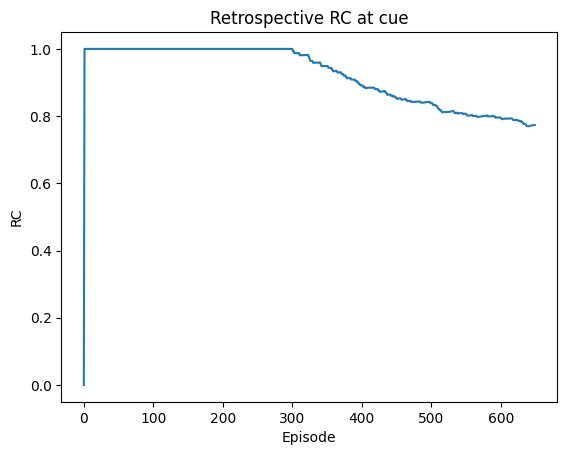

In [6]:

# 4) Retrospective contingency at cue
plt.figure()
plt.title("Retrospective RC at cue")
plt.plot(RC)
plt.xlabel("Episode"); plt.ylabel("RC")
plt.show()


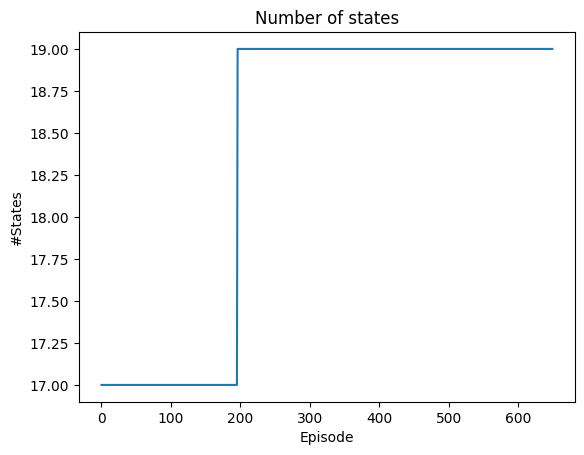

In [7]:

# 5) Number of states (clones) over time
plt.figure()
plt.title("Number of states")
plt.plot(NSTATES)
plt.xlabel("Episode"); plt.ylabel("#States")
plt.show()


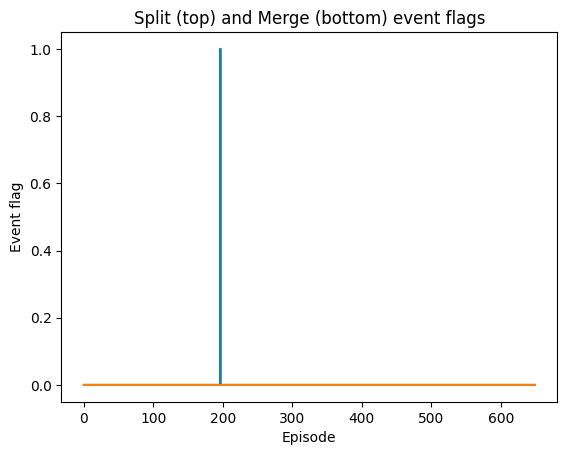

In [8]:

# 6) Split / Merge event indicators (0/1)
plt.figure()
plt.title("Split (top) and Merge (bottom) event flags")
plt.plot(SPLIT_FLAG, drawstyle='steps-post')
plt.plot(-MERGE_FLAG, drawstyle='steps-post')  # shown below zero
plt.xlabel("Episode"); plt.ylabel("Event flag")
plt.show()
